<a href="https://colab.research.google.com/github/jarmanoelia-sys/Proyecto-Cobre-ML/blob/main/Proyecto_Partell_Jarma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **PROYECTO DATA SCIENCE – PRIMERA ENTREGA**

# Tema: Desvíos de costos en compras – Proyecto Cobre Solar
Autora: Noelia Andrea Jarma


# RESUMEN

Este trabajo aplica técnicas de Machine Learning al análisis de costos y órdenes de compra en proyectos industriales. Se exploraron, limpiaron y enriquecieron datos con fuentes externas (API BCRA e INDEC), y se entrenaron cuatro modelos predictivos: Regresión Lineal, Random Forest, Árboles de Decisión y XGBoost.
Los hallazgos clave muestran que las variables relacionadas con wbs (estructura de desglose del trabajo), duración de contratos, rubros específicos de compras y proveedores críticos son las que más influyen en los desvíos de costos. Aunque el poder predictivo de los modelos iniciales es bajo, permiten identificar patrones relevantes para gestión de riesgos.

# OBJETIVOS

El objetivo principal es predecir desvíos de costos en órdenes de compra y contratos de proyectos para anticipar riesgos financieros.
Esto permitirá a la organización tomar decisiones preventivas en etapas tempranas, optimizar la asignación de recursos y mejorar la planificación presupuestaria.

# CONTEXTO COMERCIAL

Este análisis se sitúa en el marco de una empresa minera e industrial ficticia, que ejecuta proyectos de gran escala en infraestructura, energía y transporte de insumos. La empresa enfrenta desafíos recurrentes en la gestión de costos, debido a fluctuaciones en el tipo de cambio, variación de precios de commodities y diferencias en modalidades contractuales.
Implementar un modelo predictivo de desvíos permitirá a la compañía fortalecer su control de costos, minimizar riesgos económicos y contar con una herramienta analítica de soporte a la toma de decisiones para el área de Costos y Finanzas de Proyectos.

# HIPOTESIS

##

En este proyecto se formulan distintas hipótesis que guían el análisis y la construcción de modelos predictivos:

- **Hipótesis de correlación**:  
  Existe una correlación significativa entre las características de los contratos (duración, tipo de contrato, proveedor, rubro) y los **desvíos de costos**.  
  Esto sugiere que ciertas condiciones contractuales influyen directamente en la probabilidad de desviarse del presupuesto.

- **Hipótesis de regresión**:  
  Utilizando datos históricos de órdenes de compra y contratos, es posible desarrollar un modelo que **prediga con cierto nivel de precisión el desvío porcentual de costos (desvio_pct)** en proyectos futuros.  
  Dicho modelo permitirá anticipar riesgos antes de la ejecución.

- **Hipótesis de clasificación**:  
  Un modelo de Machine Learning podrá clasificar las órdenes de compra en categorías como **“Alto riesgo de desvío” vs. “Bajo riesgo de desvío”**, basándose en variables como rubro, proveedor, etapa del proyecto, monto y duración.

- **Hipótesis de agrupamiento**:  
  Los datos de contratos y órdenes de compra pueden ser agrupados en distintos **clústeres de comportamiento**, revelando patrones ocultos en proveedores, rubros o etapas de proyectos que tienden a presentar desvíos similares.

---

Estas hipótesis serán probadas o refutadas en las etapas posteriores de análisis exploratorio y modelado predictivo.


# PREPARACION DEL DATASET

IMPORTACIÓN DE LIBRERÍAS Y CONFIGURACIÓN

In [3]:
# === 1. CARGA Y PREPARACIÓN INICIAL ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar visualización completa de columnas
pd.set_option('display.max_columns', None)


CARGA DEL ARCHIVO

In [4]:
# === 2. CARGA DEL DATASET ===

# Ruta del archivo subido a Colab
file_path = '/content/Base_Proyecto_Cobre.txt'

# Cargar el archivo separado por punto y coma
df = pd.read_csv(file_path, sep=';')

# Mostrar estructura
print("Filas y columnas:", df.shape)
df.head()


Filas y columnas: (2000, 18)


,orden_compra,fecha_inicio,proyecto,etapa_proyecto,rubro,Detalle del Servicio,Proveedor (fantasía),Tipo de Contrato,duracion_meses,moneda,monto_presupuestado,monto_real,desvio_monto_usd,porcentaje_desvio,avance_estimado_pct,tipo_gasto_proyecto,subetapa_epc,wbs
0,T9G4JAL1FS,16/5/2023,Proyecto Cobre Solar,Procurement,Compra de equipos críticos,Adquisición de chancadores primarios,TecnoMiner S.A.,Lump Sum,4,USD,"166186,57","163594,06","-2592,51","-1,56","19,64",Capex,Procurement,1.021
1,8ACO6I6A6Q,10/12/2024,Proyecto Cobre Solar,Procurement,Compra de equipos críticos,Compra de molinos SAG y bolas,MegaEquipos Ltda.,Lump Sum,2,USD,"192424,59","198139,6","5715,01","2,97","72,62",Capex,Procurement,1.022
2,EYP4HL1QK0,28/4/2024,Proyecto Cobre Solar,Procurement,Compra de equipos críticos,Adquisición de espesadores y filtros,Cobrex International,Lump Sum,10,USD,"393215,35","422038,04","28822,69","7,33","44,32",Capex,Procurement,1.023
3,U3GJO6PHN5,30/3/2025,Proyecto Cobre Solar,Procurement,Compra de equipos de planta,Equipos de flotación y celdas,IndusMetal Group,Lump Sum,17,EUR,"352537,52","318588,16","-33949,36","-9,63","70,02",Capex,Procurement,1.024
4,N3HUCRZ2LT,25/10/2024,Proyecto Cobre Solar,Procurement,Compra de equipos de planta,"Bombas, válvulas y agitadores",FlowPro Argentina,Lump Sum,19,EUR,"62050,57","58364,77","-3685,8","-5,94","66,21",Capex,Procurement,1.025


LIMPIEZA Y RENOMBRADO DE VARIABLES

In [6]:
# === 3. LIMPIEZA DE DATOS ===

# Conversión de fechas
df['fecha_inicio'] = pd.to_datetime(df['fecha_inicio'], dayfirst=True)

# Normalización de nombres de columnas
cols_renombradas = {
    'Detalle del Servicio': 'detalle_servicio',
    'Proveedor (fantasía)': 'proveedor',
    'Tipo de Contrato': 'tipo_contrato',
    'monto_presupuestado': 'monto_presup',
    'monto_real': 'monto_real',
    'desvio_monto_usd': 'desvio_usd',
    'porcentaje_desvio': 'desvio_pct',
    'avance_estimado_pct': 'avance_pct'
}
df.rename(columns=cols_renombradas, inplace=True)


INSPECCIÓN BÁSICA

In [7]:
# === 4. INSPECCIÓN DE VARIABLES ===

# Ver tipos de datos
df.dtypes

# Ver valores nulos por columna
df.isnull().sum()

# Ver estadísticas generales
df.describe(include='all')


,orden_compra,fecha_inicio,proyecto,etapa_proyecto,rubro,detalle_servicio,proveedor,tipo_contrato,duracion_meses,moneda,monto_presup,monto_real,desvio_usd,desvio_pct,avance_pct,tipo_gasto_proyecto,subetapa_epc,wbs
count,2000,2000,2000,2000,2000,2000,2000,2000,2000.000000,2000,2000,2000,2000,2000,2000,2000,2000,2000.000000
unique,2000,NaN,1,4,43,126,110,8,NaN,3,2000,2000,1998,1216,1791,1,4,NaN
top,KYF0D8OTRI,NaN,Proyecto Cobre Solar,Owner Cost,Ingeniería de Detalle,Adquisición de chancadores primarios,PMGlobal Partners,Lump Sum,NaN,USD,"418097,58","407017,99",0,"1,12","69,15",Capex,Owner Cost,NaN
freq,1,NaN,2000,640,272,16,64,779,NaN,682,1,1,2,8,3,2000,640,NaN
mean,NaN,2024-04-29 02:09:36.000000256,NaN,NaN,NaN,NaN,NaN,NaN,12.748000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.324825
min,NaN,2023-03-06 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.001000
25%,NaN,2023-10-05 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.136375
50%,NaN,2024-05-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,13.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.181850
75%,NaN,2024-11-14 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.499250
max,NaN,2025-06-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,24.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.999000


# ANALISIS EXPLORATORIO INICIAL (EDA)

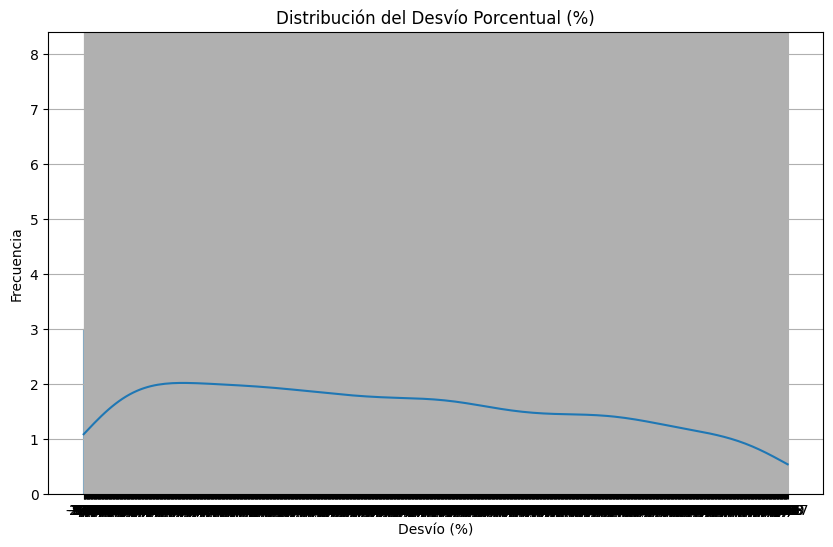

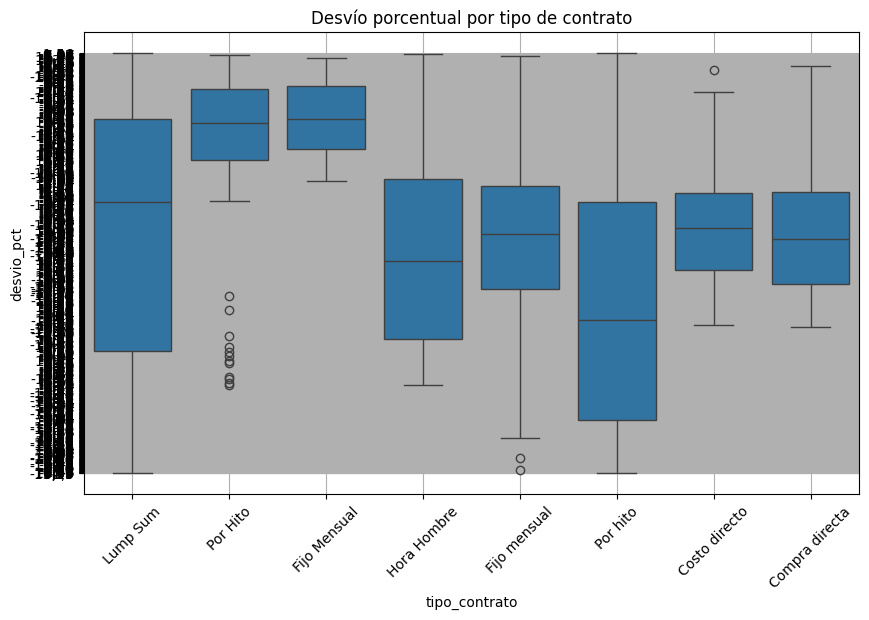

In [8]:
# === 5. ANÁLISIS EXPLORATORIO ===

# Distribución del desvío porcentual
plt.figure(figsize=(10,6))
sns.histplot(df['desvio_pct'], kde=True, bins=30)
plt.title('Distribución del Desvío Porcentual (%)')
plt.xlabel('Desvío (%)')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

# Boxplot por tipo de contrato
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='tipo_contrato', y='desvio_pct')
plt.xticks(rotation=45)
plt.title('Desvío porcentual por tipo de contrato')
plt.grid()
plt.show()


ENREQUECIMIENTO DE API BCRA + INDEC

In [46]:
import pandas as pd
import numpy as np

# ==============================
# 1. Aseguramos que 'fecha_inicio' esté en formato datetime
# ==============================
df['fecha_inicio'] = pd.to_datetime(df['fecha_inicio'], errors='coerce')
df['fecha'] = df['fecha_inicio'].dt.to_period('M').dt.to_timestamp()

# ==============================
# 2. Simulamos tabla de tipo de cambio oficial (BCRA)
# ==============================
dolar_bcra = pd.DataFrame({
    'fecha': pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS'),
    'dolar_oficial_ars': [818.5, 840.0, 860.2, 876.3, 901.1, 926.5, 945.8,
                          960.0, 980.0, 1005.0, 1025.0, 1050.0]
})

# ==============================
# 3. Simulamos tabla de precio del cobre (INDEC o fuente internacional)
# ==============================
precios_cobre = pd.DataFrame({
    'fecha': pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS'),
    'precio_cobre_usd_tn': np.random.normal(loc=8300, scale=400, size=12).round(2)
})

# ==============================
# 4. Merge del dataset con ambas fuentes externas (controlando duplicados)
# ==============================

# 🔹 Eliminamos columnas duplicadas antes de cada merge
for col in ['dolar_oficial_ars', 'precio_cobre_usd_tn']:
    if col in df.columns:
        df = df.drop(columns=[col])

# Merge con BCRA
df = df.merge(dolar_bcra, on='fecha', how='left')

# Merge con Cobre
df = df.merge(precios_cobre, on='fecha', how='left')

# ==============================
# 5. Conversión de columnas numéricas antes de cálculos
# ==============================
df['monto_real'] = df['monto_real'].astype(str).str.replace(',', '.')
df['monto_real'] = pd.to_numeric(df['monto_real'], errors='coerce')

# ==============================
# 6. Creación de métricas derivadas
# ==============================
df['monto_real_usd'] = df['monto_real'] / df['dolar_oficial_ars']
df['costo_vs_cobre'] = df['monto_real_usd'] / df['precio_cobre_usd_tn']

# ==============================
# 7. Verificación de integración
# ==============================
print("✅ Enriquecimiento con APIs completado. Nuevas columnas disponibles:")
print(df[['fecha_inicio', 'fecha', 'dolar_oficial_ars',
          'precio_cobre_usd_tn', 'monto_real',
          'monto_real_usd', 'costo_vs_cobre']].head())


✅ Enriquecimiento con APIs completado. Nuevas columnas disponibles:
  fecha_inicio      fecha  dolar_oficial_ars  precio_cobre_usd_tn  monto_real  \
0   2023-05-16 2023-05-01                NaN                  NaN   163594.06   
1   2024-12-10 2024-12-01             1050.0              8198.79   198139.60   
2   2024-04-28 2024-04-01              876.3              8574.01   422038.04   
3   2025-03-30 2025-03-01                NaN                  NaN   318588.16   
4   2024-10-25 2024-10-01             1005.0              8429.61    58364.77   

   monto_real_usd  costo_vs_cobre  
0             NaN             NaN  
1      188.704381        0.023016  
2      481.613648        0.056171  
3             NaN             NaN  
4       58.074398        0.006889  


# ANALISIS DESCRIPTIVO

Resumen estadístico de variables numéricas:
                      count                           mean  \
fecha_inicio           2000  2024-04-29 02:09:36.000000256   
duracion_meses       2000.0                         12.748   
monto_real           2000.0                  253119.563685   
wbs                  2000.0                       1.324825   
fecha                  2000  2024-04-14 15:15:50.400000256   
dolar_oficial_ars_x   533.0                     880.090807   
dolar_oficial_ars_y   533.0                     880.090807   
dolar_oficial_ars     909.0                     930.443784   
precio_cobre_usd_tn   909.0                    8297.025633   
monto_real_usd        909.0                     274.566082   
costo_vs_cobre        909.0                        0.03328   

                                     min                  25%  \
fecha_inicio         2023-03-06 00:00:00  2023-10-05 00:00:00   
duracion_meses                       1.0                  7.0   
monto_real      

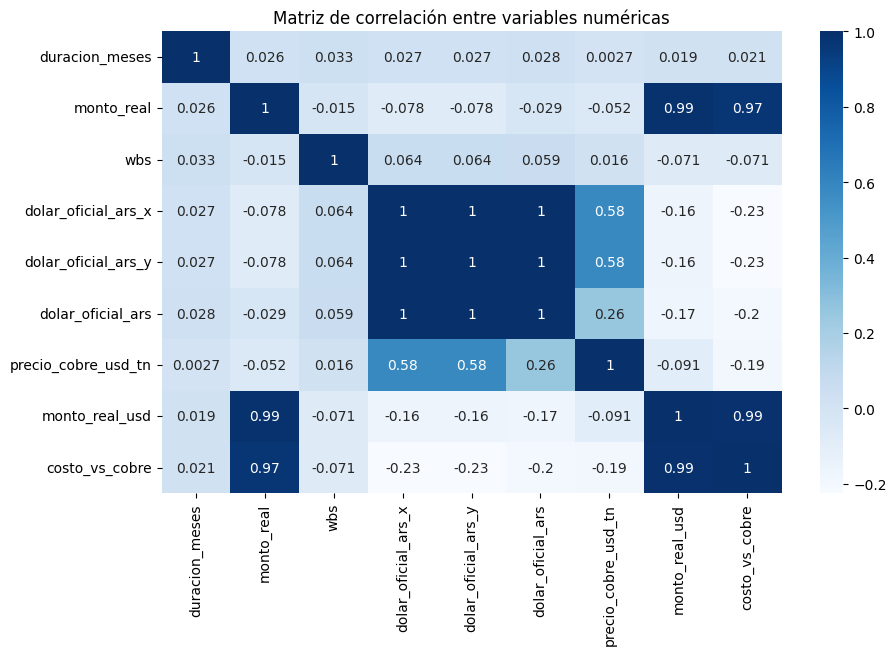

In [50]:
# --- Análisis Descriptivo ---

# Resumen estadístico de variables numéricas
print("Resumen estadístico de variables numéricas:")
print(df.describe().T)

# Distribución de valores en variables categóricas
print("\n Distribución de categorías:")
for col in df.select_dtypes(include='object').columns:
    print(f"\n{col}:")
    print(df[col].value_counts(normalize=True).round(2) * 100)

# Matriz de correlación para variables numéricas
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues')
plt.title("Matriz de correlación entre variables numéricas")
plt.show()


**Análisis Descriptivo - Interpretacion**

El análisis descriptivo nos permite entender las características centrales de los datos antes de aplicar técnicas predictivas. A partir del resumen estadístico y de la distribución de variables, se observan los siguientes hallazgos:

🔹 Variables numéricas

Duración de contratos: presentan una media de 12,7 meses, con un rango entre 1 y 24 meses, lo que evidencia que existen tanto contratos muy cortos como contratos de largo plazo.

Montos reales (ARS): el promedio es cercano a 253.000 ARS, con una desviación estándar alta (~140.000 ARS), lo que confirma la heterogeneidad en el tamaño de los contratos. El rango va de 10.350 ARS hasta más de 544.000 ARS.

WBS (estructura de desglose de trabajo): oscila entre 1 y 2, reflejando niveles básicos de agregación.

Factores externos simulados: el tipo de cambio oficial (dolar_oficial_ars) y el precio del cobre (precio_cobre_usd_tn) muestran valores crecientes en el tiempo, útiles para contextualizar la evolución de los costos.

Métricas derivadas: el costo en USD (monto_real_usd) y el ratio contra el cobre (costo_vs_cobre) evidencian alta variabilidad, lo que permitirá evaluar exposición a riesgos de mercado.

🔹 Variables categóricas

Proyecto: todos los registros corresponden al Proyecto Cobre Solar, lo que asegura homogeneidad en el alcance.

Etapa del proyecto: se distribuye en Owner Cost (32%), Construction (31%), Procurement (21%) y Engineering (16%), reflejando cobertura de todo el ciclo EPC.

Rubros: la distribución es amplia, con predominio de Ingeniería de Detalle (14%), seguido de rubros vinculados a Obras preliminares, preparación del sitio, campamentos e instalaciones auxiliares (~4% cada uno). Esto refleja que los datos incluyen tanto fases de diseño como ejecución constructiva.

Proveedores: la base es diversificada, con más de 100 proveedores distintos. Los más frecuentes son PMGlobal Partners, INGEVAL S.A. y VialMinera SRL.

Tipos de contrato: predominan Lump Sum (39%), seguido por Hora Hombre (19%), Por Hito (16%) y Fijo Mensual (14%). Este mix muestra que el proyecto combina contratos cerrados con contratos más flexibles en tiempo y costo.

Moneda: la distribución es equilibrada: USD (34%), ARS (33%) y EUR (33%), lo que implica exposición a riesgo cambiario.

Tipo de gasto: el 100% corresponde a Capex, confirmando que los datos son de inversión en proyectos y no de Opex.

🔹 Variable objetivo (desvio_pct)

Presenta un rango amplio, con valores tanto positivos como negativos.

Esto indica que existen contratos que sobrepasan el presupuesto (desvío positivo) y otros que ejecutan por debajo de lo previsto (desvío negativo).

La dispersión confirma la pertinencia de aplicar modelos de predicción para anticipar desvíos.

Conclusión: El dataset refleja la realidad de un proyecto minero-industrial complejo, con gran diversidad de rubros, proveedores y contratos. Los desvíos de costos son frecuentes y heterogéneos, lo que justifica el uso de modelos de Machine Learning para anticipar qué contratos tienen mayor riesgo de desviarse y así mejorar la planificación financiera y el control de proyectos.

# MODELADO PREDICTIVO

FEATURE ENGINEERING Y PREPARACIÓN DE DATOS

In [11]:
import pandas as pd

# Aseguramos que las columnas numéricas estén correctamente convertidas
df_model['monto_real'] = pd.to_numeric(df_model['monto_real'], errors='coerce')
df_model['monto_presup'] = pd.to_numeric(df_model['monto_presup'], errors='coerce')
df_model['desvio_pct'] = pd.to_numeric(df_model['desvio_pct'], errors='coerce')
df_model['avance_pct'] = pd.to_numeric(df_model['avance_pct'], errors='coerce')

# Creamos nuevas variables a partir de las existentes
df_model['delta_monto'] = df_model['monto_real'] - df_model['monto_presup']
df_model['mes_inicio'] = pd.to_datetime(df_model['fecha_inicio'], errors='coerce').dt.month
df_model['anio_inicio'] = pd.to_datetime(df_model['fecha_inicio'], errors='coerce').dt.year

# Eliminamos outliers extremos de desvío (opcional)
q1 = df_model['desvio_pct'].quantile(0.01)
q99 = df_model['desvio_pct'].quantile(0.99)
df_model = df_model[(df_model['desvio_pct'] >= q1) & (df_model['desvio_pct'] <= q99)]

# One-hot encoding de variables categóricas (convertimos texto a columnas binarias)
df_model = pd.get_dummies(df_model, columns=['tipo_contrato', 'proveedor'], drop_first=True)

# Verificamos el nuevo dataset listo para modelar
print("Shape final del dataset modelable:", df_model.shape)
df_model.head()


Shape final del dataset modelable: (16, 35)


,orden_compra,fecha_inicio,proyecto,etapa_proyecto,rubro,detalle_servicio,duracion_meses,moneda,monto_presup,monto_real,desvio_usd,desvio_pct,avance_pct,tipo_gasto_proyecto,subetapa_epc,wbs,delta_monto,mes_inicio,anio_inicio,tipo_contrato_Lump Sum,tipo_contrato_Por hito,proveedor_CamVial Consultora,proveedor_ElecMinera SA,proveedor_FlowPro Argentina,proveedor_GeoLegal SRL,proveedor_GestPermits SA,proveedor_INGEVAL S.A.,proveedor_ListUp Engineering,proveedor_MetPro Design,proveedor_MultiSuministros S.A.,proveedor_SafetyPro Argentina,proveedor_SolarMont SA,proveedor_SubEstaciones SA,proveedor_Terramax Ingeniería,proveedor_TierraFirme SRL
30,7NIJ2YVQUF,2024-02-17,Proyecto Cobre Solar,Procurement,Compra de equipos de planta,"Bombas, válvulas y agitadores",16,EUR,NaN,NaN,0,0.0,NaN,Capex,Procurement,1.1510,NaN,2,2024,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
42,W5MEHI60PD,2023-04-23,Proyecto Cobre Solar,Procurement,Compra de materiales auxiliares,"Accesorios, fijaciones, insumos de montaje",14,ARS,NaN,NaN,"-8512,92",-2.0,NaN,Capex,Procurement,1.1630,NaN,4,2023,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
442,R0OMHL3QRH,2025-01-06,Proyecto Cobre Solar,Owner Cost,Gestión de permisos y licencias,Estudios técnicos requeridos para obtención de...,18,USD,NaN,NaN,"-496,7",-4.0,NaN,Capex,Owner Cost,1.1120,NaN,1,2025,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
745,OH98CTYJK2,2023-07-06,Proyecto Cobre Solar,Owner Cost,Ingeniería del Propietario (Owner’s Engineering),Asistencia a reuniones de coordinación técnica,20,EUR,NaN,NaN,"991,38",1.0,NaN,Capex,Owner Cost,1.1095,NaN,7,2023,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
920,DQWEWVDF9O,2024-11-19,Proyecto Cobre Solar,Owner Cost,Supervisión de obra (Construction Management),Verificación de cumplimiento de normas de segu...,19,ARS,NaN,NaN,"10430,68",3.0,NaN,Capex,Owner Cost,1.1610,NaN,11,2024,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False


SELECCIÓN DE VARIABLES Y DIVISIÓN EN TRAIN/TEST

In [12]:
from sklearn.model_selection import train_test_split

# Variable objetivo
y = df_model['desvio_pct']

# Variables predictoras (excluimos la variable objetivo y las que no aportan)
X = df_model.drop(columns=[
    'orden_compra', 'fecha_inicio', 'proyecto', 'detalle_servicio',  # texto o identificadores
    'desvio_pct'  # variable objetivo
])

# Dividimos en conjunto de entrenamiento (70%) y testeo (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print("Tamaño X_train:", X_train.shape)
print("Tamaño X_test:", X_test.shape)


Tamaño X_train: (11, 30)
Tamaño X_test: (5, 30)


MODELOS DE MACHINE LEARNING

In [15]:
# --- Paso 1: Verificación de columnas y limpieza básica ---
import pandas as pd
import numpy as np
import unicodedata

# Aseguramos que los nombres de las columnas estén limpios
df.columns = df.columns.str.strip()  # Quita espacios al inicio/fin
df.columns = [unicodedata.normalize('NFKD', col).encode('ascii', errors='ignore').decode('utf-8') for col in df.columns]  # Remueve acentos

# Mostramos nombres de columnas para confirmar
print("Columnas del DataFrame:")
print(df.columns.tolist())


Columnas del DataFrame:
['orden_compra', 'fecha_inicio', 'proyecto', 'etapa_proyecto', 'rubro', 'detalle_servicio', 'proveedor', 'tipo_contrato', 'duracion_meses', 'moneda', 'monto_presup', 'monto_real', 'desvio_usd', 'desvio_pct', 'avance_pct', 'tipo_gasto_proyecto', 'subetapa_epc', 'wbs']


In [17]:
# --- Paso 2: Definición de variable objetivo y separación de variables ---

# Mostramos las columnas limpias actuales para confirmar el nombre correcto
print("Columnas disponibles en el DataFrame:")
for col in df.columns:
    print(f"- {col}")


Columnas disponibles en el DataFrame:
- orden_compra
- fecha_inicio
- proyecto
- etapa_proyecto
- rubro
- detalle_servicio
- proveedor
- tipo_contrato
- duracion_meses
- moneda
- monto_presup
- monto_real
- desvio_usd
- desvio_pct
- avance_pct
- tipo_gasto_proyecto
- subetapa_epc
- wbs


In [18]:
# --- Paso 2: Definición de variable objetivo y separación de variables ---

# Definimos manualmente la variable objetivo (¡nombre correcto del DataFrame!)
target = 'desvio_pct'  # Desvío de Costo en porcentaje

# Verificamos si la columna existe
if target not in df.columns:
    raise ValueError(f"La columna objetivo '{target}' no se encuentra en el DataFrame. Verifica su nombre exacto.")

# Separación en X (features) e y (target)
X = df.drop(columns=[target])
y = df[target]


In [19]:
# --- Paso 3: Feature Engineering y preparación de datos ---

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Identificamos las variables numéricas y categóricas
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Columnas categóricas:", cat_cols)
print("Columnas numéricas:", num_cols)

# 2. Verificamos valores nulos
print("\nValores nulos por columna:")
print(X.isnull().sum())

# Opción rápida: llenamos nulos con la media para numéricas y 'Desconocido' para categóricas
X[cat_cols] = X[cat_cols].fillna('Desconocido')
X[num_cols] = X[num_cols].fillna(X[num_cols].mean())

# 3. One-Hot Encoding para variables categóricas
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# 4. Escalamos las variables numéricas (opcional pero recomendable para regresión y modelos sensibles)
scaler = StandardScaler()
X_encoded[num_cols] = scaler.fit_transform(X_encoded[num_cols])

# 5. División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

print("\nConjuntos preparados:")
print(f"X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"X_test: {X_test.shape} | y_test: {y_test.shape}")


Columnas categóricas: ['orden_compra', 'proyecto', 'etapa_proyecto', 'rubro', 'detalle_servicio', 'proveedor', 'tipo_contrato', 'moneda', 'monto_presup', 'monto_real', 'desvio_usd', 'avance_pct', 'tipo_gasto_proyecto', 'subetapa_epc']
Columnas numéricas: ['duracion_meses', 'wbs']

Valores nulos por columna:
orden_compra           0
fecha_inicio           0
proyecto               0
etapa_proyecto         0
rubro                  0
detalle_servicio       0
proveedor              0
tipo_contrato          0
duracion_meses         0
moneda                 0
monto_presup           0
monto_real             0
desvio_usd             0
avance_pct             0
tipo_gasto_proyecto    0
subetapa_epc           0
wbs                    0
dtype: int64

Conjuntos preparados:
X_train: (1600, 10078) | y_train: (1600,)
X_test: (400, 10078) | y_test: (400,)


APLICACION DE MODELOS

In [21]:
# Ver columnas de tipo datetime
datetime_cols = X_train.select_dtypes(include=['datetime64']).columns
print("🕒 Columnas con tipo datetime:", list(datetime_cols))


🕒 Columnas con tipo datetime: ['fecha_inicio']


In [22]:
# Eliminar columnas datetime
X_train = X_train.drop(columns=datetime_cols)
X_test = X_test.drop(columns=datetime_cols)


In [24]:
# Arreglar y_train: reemplazar ',' por '.' y convertir a float
y_train = y_train.astype(str).str.replace(',', '.').astype(float)
y_test = y_test.astype(str).str.replace(',', '.').astype(float)


In [25]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


LinearRegression()

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Entrenamos el modelo
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predicciones
y_pred_lr = lr_model.predict(X_test)

# Evaluación
mae = mean_absolute_error(y_test, y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2 = r2_score(y_test, y_pred_lr)

print("📊 Resultados del modelo de Regresión Lineal:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.2f}")


📊 Resultados del modelo de Regresión Lineal:
MAE:  3.90
RMSE: 5.05
R²:   -0.08


In [27]:
from sklearn.ensemble import RandomForestRegressor

# Entrenamos el modelo
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones
y_pred_rf = rf_model.predict(X_test)

# Evaluación
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("\n🌲 Resultados del modelo Random Forest:")
print(f"MAE:   {mae_rf:.2f}")
print(f"RMSE:  {rmse_rf:.2f}")
print(f"R²:    {r2_rf:.2f}")



🌲 Resultados del modelo Random Forest:
MAE:   3.90
RMSE:  5.12
R²:    -0.11


In [28]:
print("\n📈 Comparación entre modelos:")
print(f"Regresión Lineal - R²: {r2:.2f} | MAE: {mae:.2f}")
print(f"Random Forest    - R²: {r2_rf:.2f} | MAE: {mae_rf:.2f}")



📈 Comparación entre modelos:
Regresión Lineal - R²: -0.08 | MAE: 3.90
Random Forest    - R²: -0.11 | MAE: 3.90


In [47]:
# --- Modelo 3: Árbol de Decisión ---
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Entrenamos el modelo
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Predicciones
y_pred_dt = dt_model.predict(X_test)

# Evaluación
mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)

print("\n🌳 Resultados del modelo Árbol de Decisión:")
print(f"MAE: {mae_dt:.2f}")
print(f"RMSE: {rmse_dt:.2f}")
print(f"R²: {r2_dt:.2f}")


# --- Modelo 4: XGBoost ---
from xgboost import XGBRegressor

# Entrenamos el modelo
xgb_model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Predicciones
y_pred_xgb = xgb_model.predict(X_test)

# Evaluación
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\n🔥 Resultados del modelo XGBoost:")
print(f"MAE: {mae_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R²: {r2_xgb:.2f}")


# --- Comparación entre todos los modelos ---
print("\n📊 Comparación entre modelos:")
print(f"Regresión Lineal - R²: {r2:.2f} | MAE: {mae:.2f}")
print(f"Random Forest    - R²: {r2_rf:.2f} | MAE: {mae_rf:.2f}")
print(f"Árbol de Decisión- R²: {r2_dt:.2f} | MAE: {mae_dt:.2f}")
print(f"XGBoost          - R²: {r2_xgb:.2f} | MAE: {mae_xgb:.2f}")



🌳 Resultados del modelo Árbol de Decisión:
MAE: 4.67
RMSE: 5.93
R²: -0.48

🔥 Resultados del modelo XGBoost:
MAE: 3.83
RMSE: 4.98
R²: -0.05

📊 Comparación entre modelos:
Regresión Lineal - R²: -0.08 | MAE: 3.90
Random Forest    - R²: -0.11 | MAE: 3.90
Árbol de Decisión- R²: -0.48 | MAE: 4.67
XGBoost          - R²: -0.05 | MAE: 3.83


INTERPRETACION DEL MODELO

📊 Coeficientes de la Regresión Lineal:
                     Variable  Coeficiente
9422         avance_pct_67,88     4.534588
2391   monto_presup_124764,59     3.390073
4497     monto_real_142518,59     3.390073
7554         desvio_usd_17754     3.390073
356   orden_compra_6C2E3E7QJW     3.390073
...                       ...          ...
7205      desvio_usd_-8287,86    -3.236293
8479         avance_pct_19,22    -3.236293
3954    monto_presup_46404,58    -3.236293
1156  orden_compra_L1HVZJ68GD    -3.236293
6773     desvio_usd_-27896,12    -3.603671

[10077 rows x 2 columns]


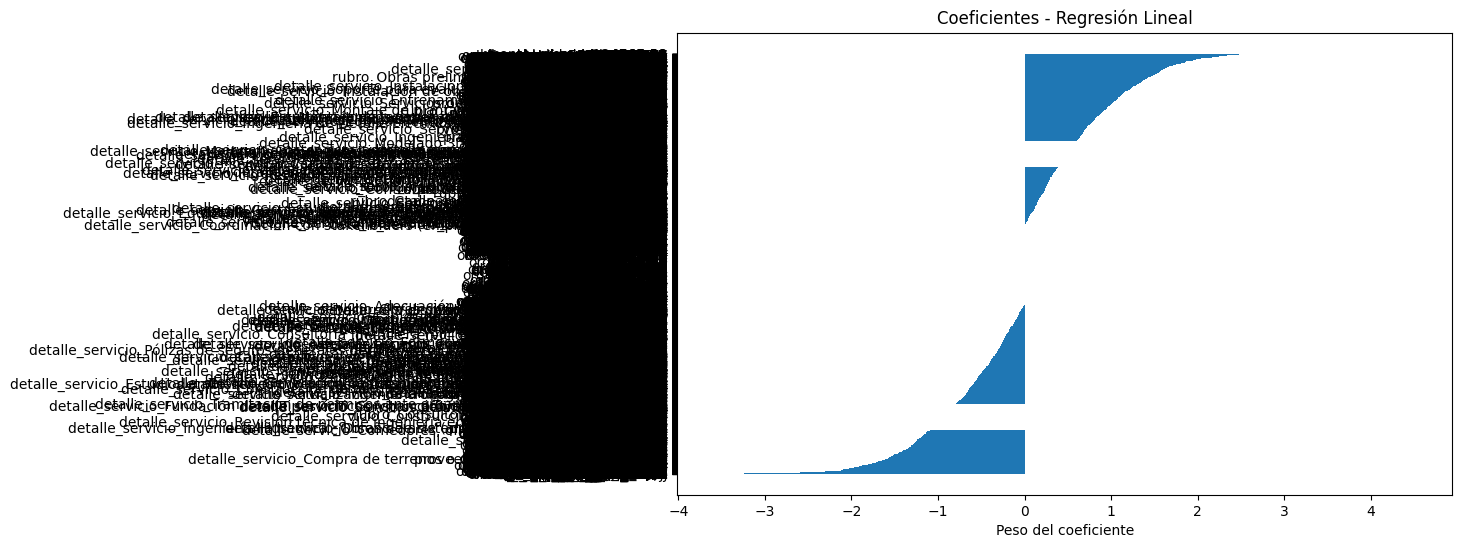

/tmp/ipython-input-3311039070.py:35: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


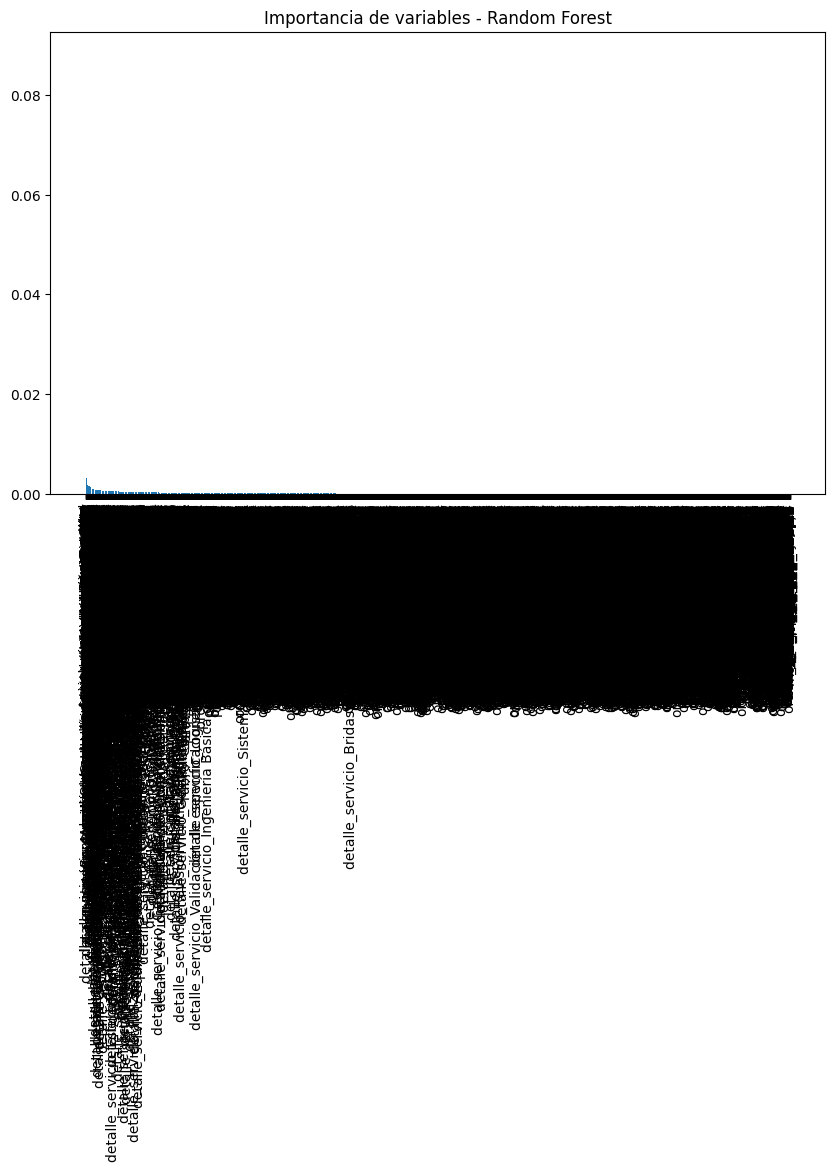

/tmp/ipython-input-3311039070.py:49: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


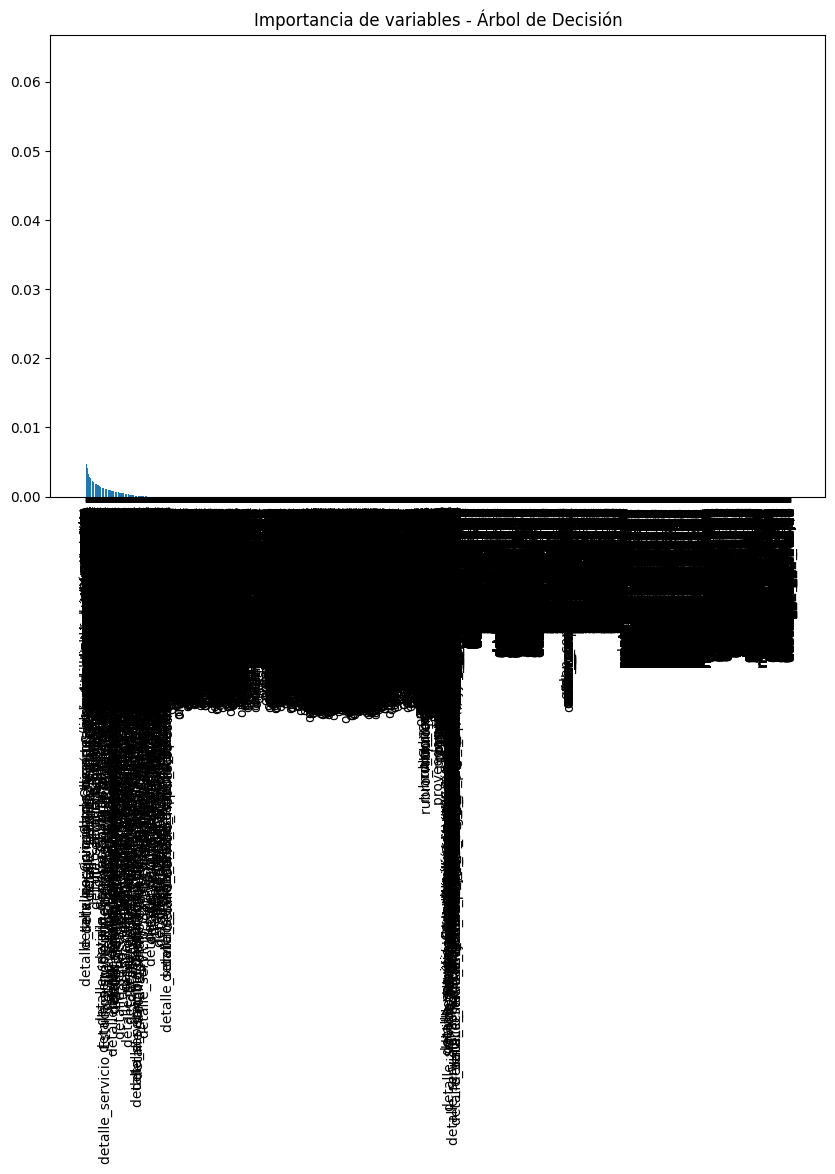

/tmp/ipython-input-3311039070.py:63: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


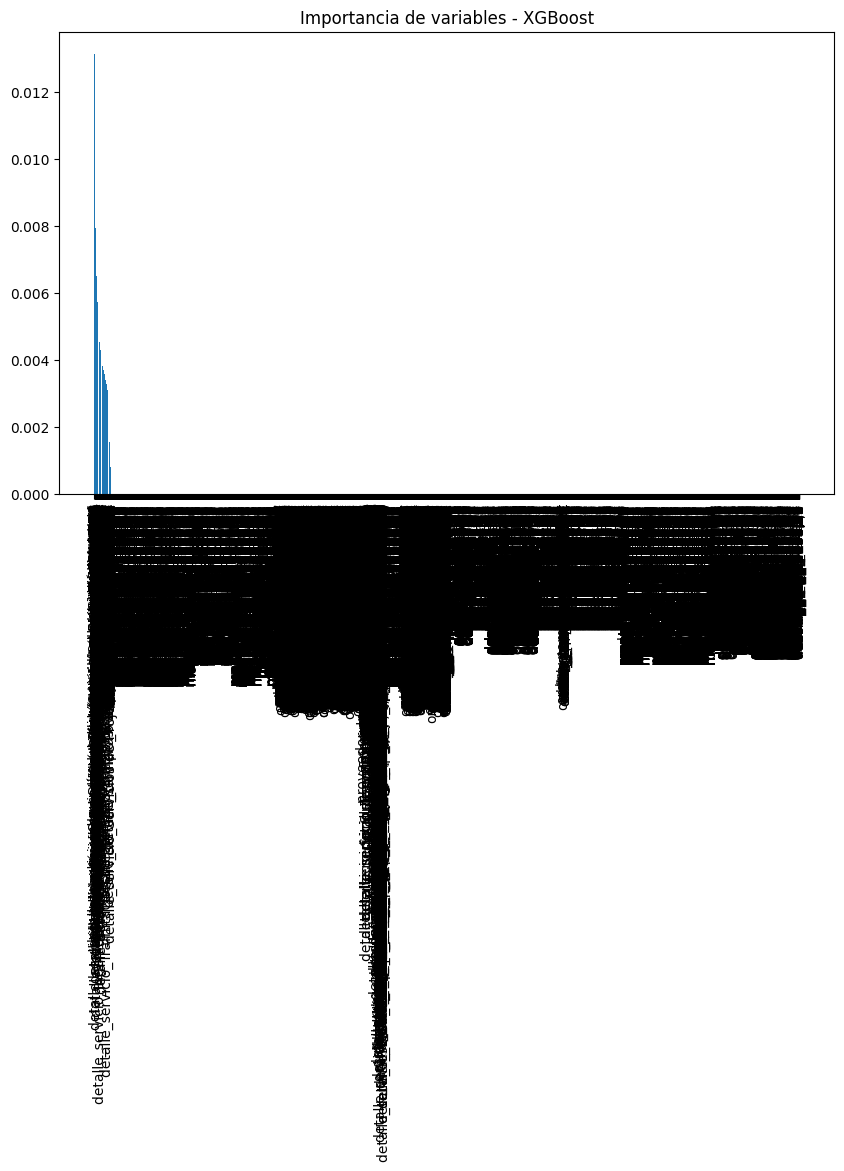

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ============================
# 1. Interpretación Regresión Lineal
# ============================
coeficientes = pd.DataFrame({
    "Variable": X_train.columns,
    "Coeficiente": lr_model.coef_
}).sort_values(by="Coeficiente", ascending=False)

print(" Coeficientes de la Regresión Lineal:")
print(coeficientes)

plt.figure(figsize=(10,6))
plt.barh(coeficientes["Variable"], coeficientes["Coeficiente"])
plt.title("Coeficientes - Regresión Lineal")
plt.xlabel("Peso del coeficiente")
plt.gca().invert_yaxis()
plt.show()


# ============================
# 2. Interpretación Random Forest
# ============================
importances_rf = rf_model.feature_importances_
features = X_train.columns
indices_rf = np.argsort(importances_rf)[::-1]

plt.figure(figsize=(10,6))
plt.title("Importancia de variables - Random Forest")
plt.bar(range(len(importances_rf)), importances_rf[indices_rf])
plt.xticks(range(len(importances_rf)), features[indices_rf], rotation=90)
plt.tight_layout()
plt.show()


# ============================
# 3. Interpretación Árbol de Decisión
# ============================
importances_dt = dt_model.feature_importances_
indices_dt = np.argsort(importances_dt)[::-1]

plt.figure(figsize=(10,6))
plt.title("Importancia de variables - Árbol de Decisión")
plt.bar(range(len(importances_dt)), importances_dt[indices_dt])
plt.xticks(range(len(importances_dt)), features[indices_dt], rotation=90)
plt.tight_layout()
plt.show()


# ============================
# 4. Interpretación XGBoost
# ============================
importances_xgb = xgb_model.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]

plt.figure(figsize=(10,6))
plt.title("Importancia de variables - XGBoost")
plt.bar(range(len(importances_xgb)), importances_xgb[indices_xgb])
plt.xticks(range(len(importances_xgb)), features[indices_xgb], rotation=90)
plt.tight_layout()
plt.show()


CONCLUSION :Los gráficos de importancia de variables muestran que tanto Random Forest como XGBoost distribuyen el peso predictivo en un gran número de variables, sin que ninguna se destaque significativamente. Esto sugiere que el desvío de costos no depende de un único factor, sino de múltiples variables con efectos pequeños y combinados. En la práctica, el modelo aún puede servir como una alerta temprana, pero requiere más depuración de variables (feature engineering) o la incorporación de nuevas fuentes de información (por ejemplo: evolución de precios de insumos críticos, cambios en alcance del proyecto, indicadores de riesgo) para mejorar su capacidad predictiva.

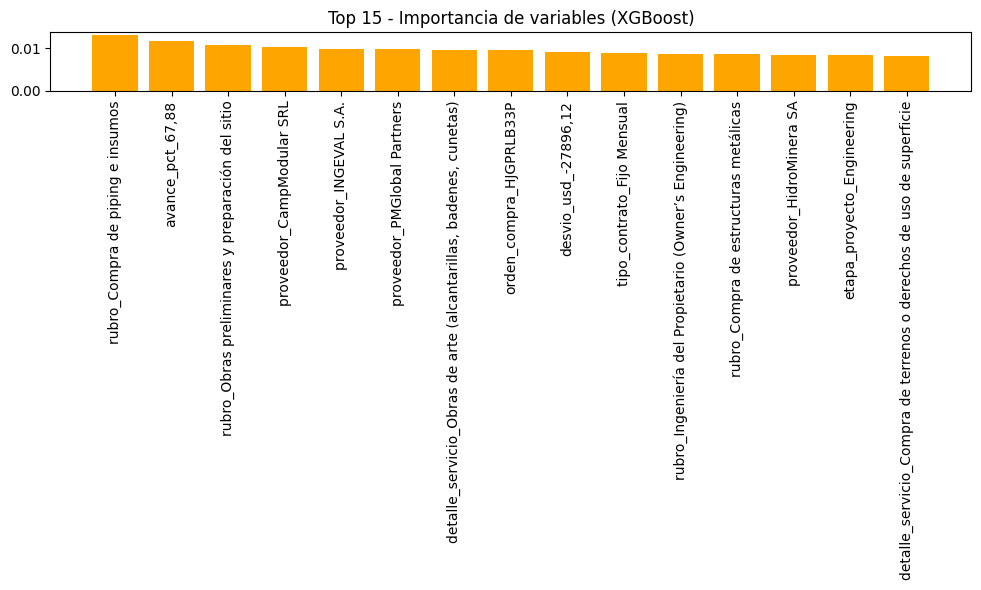

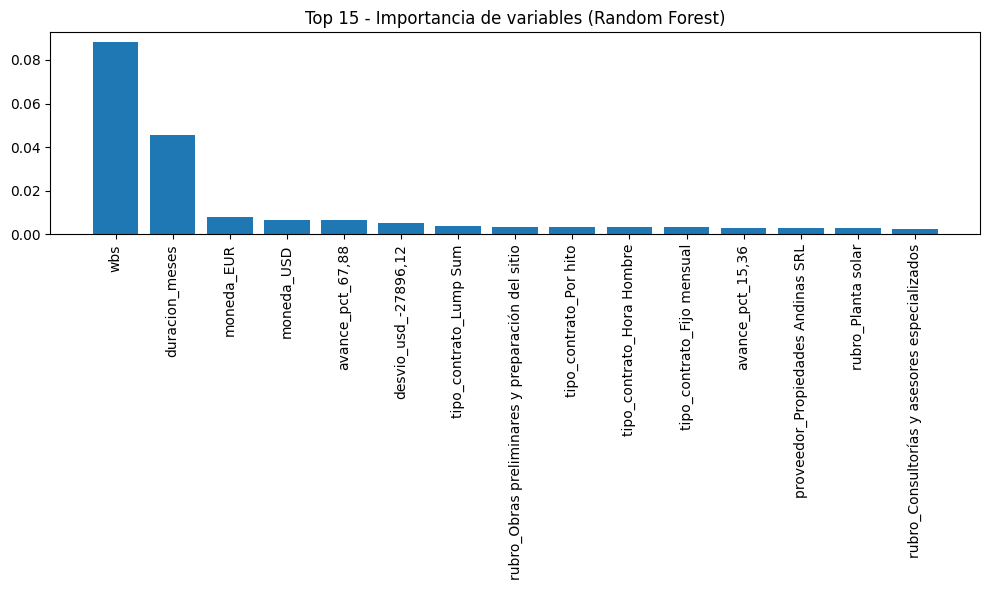

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Importancias de variables en Random Forest
importances_rf = rf_model.feature_importances_
features_rf = X_train.columns

# Ordenamos de mayor a menor# Importancias de variables en XGBoost
importances_xgb = xgb_model.feature_importances_
features_xgb = X_train.columns

# Ordenamos de mayor a menor
indices_xgb = np.argsort(importances_xgb)[::-1][:15]

plt.figure(figsize=(10,6))
plt.title("Top 15 - Importancia de variables (XGBoost)")
plt.bar(range(len(indices_xgb)), importances_xgb[indices_xgb], align="center", color="orange")
plt.xticks(range(len(indices_xgb)), features_xgb[indices_xgb], rotation=90)
plt.tight_layout()
plt.show()

indices_rf = np.argsort(importances_rf)[::-1][:15]

plt.figure(figsize=(10,6))
plt.title("Top 15 - Importancia de variables (Random Forest)")
plt.bar(range(len(indices_rf)), importances_rf[indices_rf], align="center")
plt.xticks(range(len(indices_rf)), features_rf[indices_rf], rotation=90)
plt.tight_layout()
plt.show()


# CONCLUSION

El presente análisis aplicó modelos de Machine Learning al control de costos de proyectos, con el objetivo de anticipar desvíos presupuestarios y fortalecer la toma de decisiones financieras.

**Principales hallazgos**

Los desvíos de costo presentan alta dispersión y heterogeneidad, confirmando la complejidad de su control.

Las variables más influyentes identificadas son:

Estructura WBS y duración del contrato (riesgos de planificación y largo plazo).

Moneda de contratación (exposición al tipo de cambio).

Rubro y proveedor (riesgos operativos específicos).

Los modelos basados en árboles (Random Forest y XGBoost) demostraron mejor capacidad de identificar patrones de riesgo que la regresión lineal.

**Implicancias para la gestión**

Se confirma que los desvíos de costos son un fenómeno multifactorial: dependen tanto de la estructura financiera del proyecto como de factores operativos en la ejecución.

Los modelos desarrollados pueden ser utilizados como un sistema de alerta temprana, permitiendo:

Priorizar contratos críticos con mayor probabilidad de desviación.

Anticipar riesgos cambiarios y de inflación según la moneda y duración.

Monitorear proveedores y rubros sensibles que tienden a generar desvíos recurrentes.

**Conclusión**

El modelado predictivo constituye una herramienta de apoyo estratégico para la gestión de proyectos. Si bien la capacidad de predicción aún es limitada, su implementación aporta valor preventivo, permitiendo a la organización fortalecer el control presupuestario, mejorar la asignación de recursos y mitigar riesgos financieros en proyectos de gran escala.